

# Libraries import, data loading, features encoding 

In [ ]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Libraries to be used are imported
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os 
import fnmatch
from os import listdir
from glob import glob
import shutil
from sklearn.utils import shuffle
import pickle
from PIL import Image
import sklearn
import cv2 
from google.colab.patches import cv2_imshow 
from keras.preprocessing import image
from sklearn.utils.class_weight import compute_class_weight
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter
from skimage.morphology import disk
from skimage import color
from skimage.feature import local_binary_pattern
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from scipy.stats import kurtosis, skew
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import learning_curve
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from sklearn import preprocessing
from sklearn.metrics import classification_report, balanced_accuracy_score
import skimage
from skimage import io, exposure, morphology, filters, color, segmentation, feature, measure, img_as_float, img_as_ubyte, transform
from scipy import ndimage as ndi
from xgboost import XGBClassifier
import pandas as pd
import seaborn as sns 
import random
import imutils
import math

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#Fixing of random seed
random.seed(42)
#Load of important files for Machine Learning Classification Pipeline.
#Preprocessed images for training, test and validation datasets from the Image Processing Pipeline.
preprocessed_images_train=np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/preprocessed_images_train_256.npy')
preprocessed_images_test= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/preprocessed_images_test_256.npy')
preprocessed_images_val= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/preprocessed_images_val_256.npy')

#Segmented images for training, test and validation datasets from the Image Processing Pipeline. 
segmented_images_train_ip=np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/segmented_image_2000.npy')
segmented_images_test_ip= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/segmented_images_test_256.npy')
segmented_images_val_ip=np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/preprocessed_images_val_256.npy')

#Segmented images for training, test and validation datasets from the Deep Learning Pipeline without post processing 
#train_segmented_images_dl= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/unet_dice_bce_adam_masks_256.npy')
#test_segmented_images_dl=np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/test_unet_dice_bce_adam_masks_256.npy')
#val_segmented_images_dl=np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/val_unet_dice_bce_adam_masks_256.npy')

#Segmented images for training, test and validation datasets from the Deep Learning Pipeline with Post Processing
#(extraction of largest area component and elimination of noisy elements)
segmented_images_train_dl= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/segmented_images_train_dl.npy')
segmented_images_test_dl=np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/segmented_images_test_dl.npy')
segmented_images_val_dl=np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/segmented_images_val_dl.npy')

#Original Images 
original_images=np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/resized_images.npy')

#Training, Validation and Test ground truth masks. 
train_masks= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/train_masks.npy')
val_masks= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/val_masks.npy')
test_masks= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/test_masks.npy')

#Training, Validation and Test labels. 
train_labels=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/ISIC-2017_Training_Part3_GroundTruth.csv')
val_labels= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/ISIC-2017_Validation_Part3_GroundTruth.csv')
test_labels= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

#Tags (IDs) for images in training, validation and test datasets. 
train_tags= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/train_tags.npy')
val_tags= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/val_tags.npy')
test_tags= np.load('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/test_tags.npy')

In [ ]:
#Function to encode labels. The function adds the column of bening cases and returns a dataframe with the labels and a vector with labels in ordinal encoding 
#Generated label encoding is the following: (0:benign, 1: melanoma, 2: seborrheic keratosis )
def encoding_labels(labels):
  #Inputs: 
  #labels: dataframe with initial labels provided by challenge (with melanoma and seborrheic keratosis classes 
  
  #Input Dataframe is recovered and converted into a numpy array. 
  encoded_labels= labels.loc[:,['melanoma', 'seborrheic_keratosis']]
  encoded_labels= encoded_labels.to_numpy()
  final_labels=[]
  bening= np.array([0,0])
  #The label for benign cases is added as the first column of the dataframe 
  for i in range(len(encoded_labels)):
    if np.array_equal(encoded_labels[i], bening) == True:
      final_labels.append(np.insert(encoded_labels[i],0,1))
    else: 
      final_labels.append(np.insert(encoded_labels[i],0,0))
  #Dataframe of labels is generated 
  final_labels= np.array(final_labels)
  new_dataframe= {'benign': final_labels[:,0],'melanoma': final_labels[:,1],'seborrheic_keratosis':final_labels[:,2]}
  new_dataframe= pd.DataFrame(new_dataframe, columns= ['benign', 'melanoma', 'seborrheic_keratosis'])
  #IDs of the images are stored in a variable 
  ids= pd.DataFrame(labels.loc[:,'image_id'])
  new_dataframe = pd.concat([ids,new_dataframe],axis=1)
  dataset_labels= new_dataframe.iloc[:,1:4].to_numpy()
  #Labels are converted from one hot to ordinal encoding 
  labels_ordinal= np.argmax(dataset_labels,axis=1)
  return new_dataframe, labels_ordinal

# Definition of variables for training the models

In [ ]:
#Definition of variables for training the models
#Training, validation and test images 
X_train= segmented_images_train_dl
X_val= segmented_images_val_dl
X_test= segmented_images_test_dl
#Training, validation and test pre-processed images
X_train_images= preprocessed_images_train
X_test_images= preprocessed_images_test
X_val_images= preprocessed_images_val
#Training, validation and test masks
X_train_masks= train_masks
X_val_masks= val_masks
X_test_masks= test_masks
#Training, validation and test images IDs (tags)
X_train_tags= train_tags
X_test_tags= test_tags
X_val_tags= val_tags
#Generation of training, validation and test labels both in dataframe (one-hot encoding) and vector(ordinal encoding)
y_train_dataframe, y_train = encoding_labels(train_labels)
y_test_dataframe,y_test= encoding_labels(test_labels)
y_val_dataframe, y_val= encoding_labels(val_labels)
#Generation of third dataset for experiments: an augmented training dataset is generated by including the data from the validation set
X_train_extended= np.concatenate((X_train,X_val), axis=0)
y_train_extended= np.concatenate((y_train,y_val),axis=0)
X_train_images_extended= np.concatenate((X_train_images,X_val_images), axis=0)
X_train_tags_extended= np.concatenate((X_train_tags,X_val_tags),axis=0)

In [ ]:
y_train_dtfr= pd.DataFrame(y_train, columns=['Diagnostic'])
y_train_ext_dtfr= pd.DataFrame(y_train_extended, columns=['Diagnostic'])
y_val= pd.DataFrame(y_val,columns=['Diagnostic'])

0    1372
1     374
2     254
Name: Diagnostic, dtype: int64

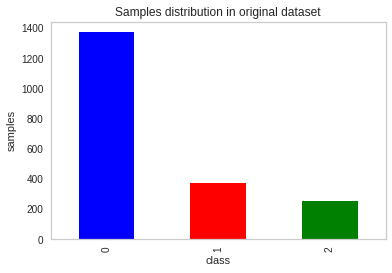

In [ ]:
y_train_dtfr['Diagnostic'].value_counts().plot.bar(grid=False, color=['blue','red','green'],xlabel='class', ylabel='samples', title='Samples distribution in original dataset')
y_train_dtfr['Diagnostic'].value_counts()

0    78
2    42
1    30
Name: Diagnostic, dtype: int64

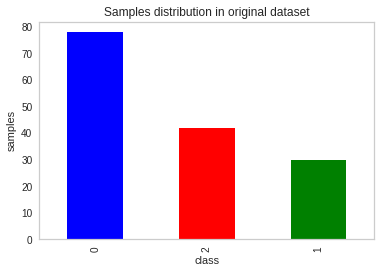

In [ ]:
y_val['Diagnostic'].value_counts().plot.bar(grid=False, color=['blue','red','green'],xlabel='class', ylabel='samples', title='Samples distribution in original dataset')
y_val['Diagnostic'].value_counts()

0    1450
1     404
2     296
Name: Diagnostic, dtype: int64

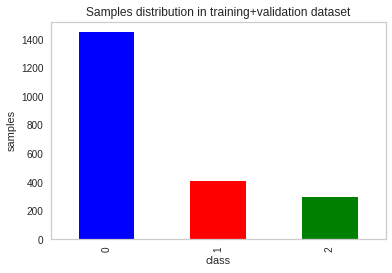

In [ ]:
y_train_ext_dtfr['Diagnostic'].value_counts().plot.bar(grid=False, color=['blue','red','green'],xlabel='class', ylabel='samples', title='Samples distribution in training+validation dataset')
y_train_ext_dtfr['Diagnostic'].value_counts()

# Functions for extracting region of interest (lesion) and largest area component

In [ ]:
#Extract Lesion: Function to extract ROI (Region of Interest) of the preprocessed images. 
def extract_lesion(image,mask):
  #Inputs: Image: Pre-processed image from Image processing Pipeline
  #Mask: Mask representing the area to be extracted (lesion)
  im= image.copy()
  black_image= np.zeros(im.shape).astype(im.dtype)
  #Finding the contour in the mask provided as input
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.fillPoly(black_image,contours,(255,255,255))
  #Bitwise and between black image and input image to get the region of interest
  result = cv2.bitwise_and(im, black_image)
  return result

In [ ]:
#Extract Largest Component: Function to fill holes inside a lesion generated mask, and also 
#to eliminate small noisy elements that are not part of the lesion. This function is used as post-processing for the masks that were
#generated from Deep Learning. 
def extract_largest_component(image):
  #Inputs: Image: image to be analyzed

  #The contours present in the image are found 
  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  #If there is no contour (not image found), then the contour image is the the one that was given as input
  if len(contours)==0:
    contour_image= image
  #In case there are contours in the image
  else:
    #Area is calculated for each of the contours and the one with maximum area is preserved. 
    areas= [cv2.contourArea(i) for i in contours]
    largest_contour_idx= areas.index(max(areas))
    black_image= np.zeros_like(image,np.uint8)
    contour_image= cv2.drawContours(black_image,contours,largest_contour_idx,(255,255,255),-1)
  return contour_image

# Region of Interest Extraction

In [ ]:
#Vectors to save the lesions for the training set (getting the region of interest) for features calculation 
lesions_train=[]
for i in range(len(X_train_images)):
  lesions_train.append(extract_lesion(X_train_images[i], X_train[i]))

In [ ]:
#Vectors to save the lesions for the extended training set (getting the region of interest) for features calculation 
lesions_train_extended=[]
for i in range(len(X_train_extended)):
  lesions_train_extended.append(extract_lesion(X_train_images_extended[i], X_train_extended[i]))

In [ ]:
#Vectors to save the lesions for the test set (getting the region of interest) for features calculation 
lesions_test=[]
for i in range(len(X_test_images)):
  lesions_test.append(extract_lesion(X_test_images[i], X_test[i]))

# Feature Extraction Function

In [ ]:
#Feature Extractor: Function that calculates the features for a given image and outputs them as a dataframe. 
def feature_extractor(lesion_images,segmentation_images,flag):
  
  #Inputs: lesion_images: image with the identified region of interest
  #segmentation_images: mask with the segmentation for that given image generated from Deep Learning Pipeline. 
  #flag: variable to decide for which dataset the features are being calculated. 0 for training set, 1 for test set, 2 for validation set and 3 for extended training set. 
  if flag==0:
    tags= X_train_tags
  elif flag==1: 
    tags= X_test_tags
  elif flag==2:
    tags= X_val_tags
  elif flag==3:
    tags= X_train_tags_extended
  else:
    print('Introduce a valid flag. 0 for train set, 1 for test set or 2 for validation set')

  #Initialization of all lists in which the value for each feature will be stored. 
  convexity_defects=[]
  circularity_index = []
  lesion_diameter=[]
  mean_B=[]
  mean_G=[]
  mean_R=[]
  mean_BGR=[]
  std_B=[]
  std_G=[]
  std_R=[]
  std_BGR=[]
  max_B=[]
  max_G=[]
  max_R=[]
  mean_corr=[]
  mean_homogeneity=[]
  mean_energy=[]
  mean_contrast=[]
  mean_B_h1=[]
  mean_G_h1=[]
  mean_R_h1=[]
  mean_BGR_h1=[]
  mean_B_h2=[]
  mean_G_h2=[]
  mean_R_h2=[]
  mean_BGR_h2=[]
  mean_B_diff=[]
  mean_G_diff=[]
  mean_R_diff=[]
  mean_BGR_diff=[]
  mean_H=[]
  mean_S=[]
  mean_V=[]
  mean_HSV=[]
  mean_Y=[]
  mean_CR=[]
  mean_CB=[]
  mean_YCRCB=[]
  mean_L=[]
  mean_A=[]
  mean_BLAB=[]
  mean_LAB=[]
  skew_values=[]
  kurtosis_values=[]
  entropy=[]
  original_pixels=[]

  #Calculation of features for the lesion entered as input
  for i in range(len(segmentation_images)):
    #Finding the contours and area of the biggest contour in the image
    contours,_= cv2.findContours(segmentation_images[i],cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE )
    area= cv2.contourArea(contours[0])
    #Diameter of the lesion calculation 
    diameter= round(np.sqrt((4*area)/(np.pi)),3)
    lesion_diameter.append(diameter)
    #Perimeter of the lesion calculation 
    perimeter= cv2.arcLength(contours[0],True)
    #Circularity Index calculation 
    circularity= round((4*np.pi*area)/(perimeter**2),3)
    circularity_index.append(circularity)
    #Calculation of mean and standard deviation of intensities in the blue, green and red channels. 
    mean_std= cv2.meanStdDev(lesion_images[i],mask= segmentation_images[i])
    mean_B.append(np.round(mean_std[0][0][0],3))
    mean_G.append(np.round(mean_std[0][1][0],3))
    mean_R.append(np.round(mean_std[0][2][0],3))
    mean_BGR.append(np.round(np.mean(mean_std[0]),3))
    std_B.append(np.round(mean_std[1][0][0],3))
    std_G.append(np.round(mean_std[1][1][0],3))
    std_R.append(np.round(mean_std[1][2][0],3))
    std_BGR.append(np.round(np.mean(mean_std[1]),3))
    max_B.append(np.amax(lesion_images[i][:,:,0]))
    max_G.append(np.amax(lesion_images[i][:,:,1]))
    max_R.append(np.amax(lesion_images[i][:,:,2]))
    #Calculation of GLCM matrix to extract mean correlation, homogeneity, energy and contrast of the lesion
    im= lesion_images[i].copy()
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    glcm = feature.greycomatrix(im, distances=[1,2,3], angles=[0, np.pi/4, np.pi/2, np.pi * 3/2], levels=256)
    mean_corr.append(np.round(np.mean(feature.greycoprops(glcm,prop='correlation')),3))
    mean_homogeneity.append(np.round(np.mean(feature.greycoprops(glcm,prop='homogeneity')),3))
    mean_energy.append(np.round(np.mean(feature.greycoprops(glcm,prop='energy')),3))
    mean_contrast.append(np.round(np.mean(feature.greycoprops(glcm,prop='contrast')),3))
    #Splitting the lesion images in two equal halves and getting the mean intensity of the blue, green and red channel for each haf
    lesionh1= lesion_images[i].copy()
    lesionh2= lesion_images[i].copy()
    maskh1= segmentation_images[i].copy()
    maskh2= segmentation_images[i].copy()
    lesionh1[:,int((lesionh1.shape[1]/2)-1):]=0
    maskh1[:,int((maskh1.shape[1]/2)-1):]=0
    lesionh2[:,:int((lesionh2.shape[1]/2)-1)]=0
    maskh2[:,:int((maskh2.shape[1]/2)-1)]=0
    meanh1= cv2.mean(lesionh1,mask= maskh1)
    meanh2= cv2.mean(lesionh2,mask= maskh2)   
    mean_B_h1.append(np.round(meanh1[0],3))
    mean_G_h1.append(np.round(meanh1[1],3))
    mean_R_h1.append(np.round(meanh1[2],3))
    mean_BGR_h1.append(np.round(np.mean(meanh1[:3]),3))
    mean_B_h2.append(np.round(meanh2[0],3))
    mean_G_h2.append(np.round(meanh2[1],3))
    mean_R_h2.append(np.round(meanh2[2],3))
    mean_BGR_h2.append(np.round(np.mean(meanh2[:3]),3))
    #Getting mean intensity for H, S and V channels of the image converted to HSV. 
    image_HSV= cv2.cvtColor(lesion_images[i],cv2.COLOR_BGR2HSV)
    mean_hsv_channel= cv2.meanStdDev(image_HSV,mask= segmentation_images[i])
    mean_H.append(np.round(mean_hsv_channel[0][0][0],3))
    mean_S.append(np.round(mean_hsv_channel[0][1][0],3))
    mean_V.append(np.round(mean_hsv_channel[0][2][0],3))
    mean_HSV.append(np.round(np.mean(mean_hsv_channel[0]),3))
    #Getting mean intensity for Y, CR and CB channels of the image converted to YCRCB.
    image_YCRCB= cv2.cvtColor(lesion_images[i],cv2.COLOR_BGR2YCrCb)
    mean_ycrcb_channel= cv2.meanStdDev(image_YCRCB,mask= segmentation_images[i])
    mean_Y.append(np.round(mean_ycrcb_channel[0][0][0],3))
    mean_CR.append(np.round(mean_ycrcb_channel[0][1][0],3))
    mean_CB.append(np.round(mean_ycrcb_channel[0][2][0],3))
    mean_YCRCB.append(np.round(np.mean(mean_ycrcb_channel[0]),3))
    #Calculation of Skweness, Kurtosis, Entropy and Sum of Pixel intensities for the lesion. 
    skew_values.append(skew(lesion_images[i],axis=None))
    kurtosis_values.append(kurtosis(lesion_images[i],axis=None))
    entropy.append(skimage.measure.shannon_entropy(lesion_images[i]))
    original_pixels.append(np.sum(lesion_images[i].reshape(-1)))
    #Getting mean intensity for L, A and B channels of the image converted to LAB.
    image_LAB= cv2.cvtColor(lesion_images[i],cv2.COLOR_BGR2LAB)
    mean_lab_channel= cv2.meanStdDev(image_YCRCB,mask= segmentation_images[i])
    mean_L.append(np.round(mean_lab_channel[0][0][0],3))
    mean_A.append(np.round(mean_lab_channel[0][1][0],3))
    mean_BLAB.append(np.round(mean_lab_channel[0][2][0],3))
    mean_LAB.append(np.round(np.mean(mean_lab_channel[0]),3))
    #Calculation of convexity defects of the lesion 
    hull= cv2.convexHull(contours[0],returnPoints=False)
    defects= cv2.convexityDefects(contours[0],hull)
    counter=0 
    if np.array_equal(defects, None) == True:
      convexity_defects.append(0)
    else:
      for j in range(defects.shape[0]):
        s,e,f,d= defects[j,0]
        start= contours[0][s][0]
        end= contours[0][e][0]
        far= contours[0][f][0]
        if np.linalg.norm(start-end) >15:
          counter+=1
      convexity_defects.append(counter)
  std_B= np.array(std_B)
  std_G= np.array(std_G)
  std_R= np.array(std_R)
  max_B= np.array(max_B)
  max_G= np.array(max_G)
  max_R= np.array(max_R)
  #Calculation of color varietion of the B,G, and R channels of the lesion. 
  CV_B= np.round(std_B/max_B,3)
  CV_G= np.round(std_G/max_B,3)
  CV_R= np.round(std_R/max_R,3)
  #Storage of the results of each feature in its corresponding list
  mean_B_h1=np.array(mean_B_h1)
  mean_G_h1=np.array(mean_G_h1)
  mean_R_h1=np.array(mean_R_h1)
  mean_BGR_h1=np.array(mean_BGR_h1)
  mean_B_h2=np.array(mean_B_h2)
  mean_G_h2=np.array(mean_G_h2)
  mean_R_h2=np.array(mean_R_h2)
  mean_BGR_h2=np.array(mean_BGR_h2)
  mean_B_diff= np.abs(mean_B_h1-mean_B_h2)
  mean_G_diff= np.abs(mean_G_h1-mean_G_h2)
  mean_R_diff= np.abs(mean_R_h1-mean_R_h2)
  mean_BGR_diff= np.abs(mean_BGR_h1-mean_BGR_h2)
  
  #Creation of features dataframe 
  features_dict= {'Tag': tags,'Convexity Defects':convexity_defects, 'Circularity Index': circularity_index, 'Lesion Diameter': lesion_diameter,
                  'MeanB': mean_B,'MeanG':mean_G,'meanR': mean_R, 'meanBGR': mean_BGR,'StdB': std_B, 'StdG': std_G, 'StdR':std_R,
                  'StdBGR': std_BGR, 'maxB': max_B,'maxG': max_G, 'max_R': max_R, 'CV_B': CV_B, 'CV_G': CV_G, 'CV_R': CV_R, 
                  'MeanCorr': mean_corr,'MeanHomogeneity': mean_homogeneity, 'MeanEnergy': mean_energy, 'MeanContrast': mean_contrast,
                  'meanH': mean_H, 'meanS':mean_S,'meanV': mean_V, 'meanHSV': mean_HSV,
                  'meanY': mean_Y, 'meanCR': mean_CR, 'meanCB': mean_CB, 'meanYCRCB': mean_YCRCB,
                  'skewness': skew_values, 'kurtosis': kurtosis_values, 'entropy': entropy, 'pixel_intensities':original_pixels, 'meanLAB': mean_LAB, 'mean_L': mean_L,
                  'mean_A': mean_A, 'mean_BLAB': mean_BLAB,  'meanB_h1': mean_B_h1,'meanG_h1': mean_G_h1, 'meanR_h1': mean_R_h1, 'meanBGR_h1': mean_BGR_h1, 'meanB_h2': mean_B_h2,
                  'meanG_h2': mean_G_h2, 'meanR_h2': mean_R_h2, 'meanBGR_h2': mean_BGR_h2, 'meanB_diff': mean_B_diff, 'meanG_diff': mean_G_diff,
                  'meanR_diff': mean_R_diff, 'meanBGR_diff': mean_BGR_diff
                  }
  features= pd.DataFrame.from_dict(features_dict)
  return features

# Calculation and processing of features

In [ ]:
#Calculation of features for the training, test, and training extended dataset. 
train_features= feature_extractor(lesions_train, X_train, 0)
test_features= feature_extractor(lesions_test,X_test, 1)
train_extended_features= feature_extractor(lesions_train_extended,X_train_extended,3)

In [ ]:
#Storage of features in drive. 
train_features.to_csv('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/train_features_2.csv',index=False)
test_features.to_csv('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/test_features_2.csv',index=False)
train_extended_features.to_csv('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/train_features_extended_2.csv',index=False)

In [ ]:
train_features= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/train_features.csv')
test_features= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/test_features.csv')
train_extended_features= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/train_features_extended.csv')

In [ ]:
#Features dataframes are converted to numpy arrays, excluding the IDs column 
X_train_features= train_features.to_numpy()
X_test_features= test_features.to_numpy()
X_train_features_extended= train_extended_features.to_numpy()
X_train_features= X_train_features[:,1:]
X_test_features= X_test_features[:,1:]
X_train_features_extended= X_train_features_extended[:,1:]
#Features are scaled using StandardScaled
scaler= StandardScaler().fit(X_train_features)
scaler2= StandardScaler().fit(X_train_features_extended)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)
X_train_scaled_extended= scaler2.transform(X_train_features_extended)
X_test_scaled2= scaler2.transform(X_test_features)

# Feature Selection and Model Evaluation Functions

In [ ]:
#Feature Selection Function: Performs SelectKBest function and returns the new training and test sets, as well as the names of the features selected. 
def feature_selection(X_train,y_train,X_test,k,train_features):
  #Inputs:
  #X_train: training set 
  #Selection of k best features
  selector= SelectKBest(score_func=f_classif,k=k )
  selector.fit(X_train,y_train)
  #Getting new data vectors with the selected features 
  X_train_new= selector.transform(X_train)
  X_test_new= selector.transform(X_test)
  feat_data= train_features.columns
  #Finding the names of the selected features 
  selected_features= feat_data[selector.get_support(indices=True)].to_list()
  return X_train_new,X_test_new, selected_features

In [ ]:
#Data Balancing in order to tackle data imbalance. technique used: SMOTE 
ros = SMOTE(sampling_strategy='auto', random_state= 42)
X_train_resampled,y_train_resampled= ros.fit_resample(X_train_scaled,y_train)
print(np.bincount(y_train_resampled))
X_train_resampled_extended, y_train_resampled_extended= ros.fit_resample(X_train_scaled_extended,y_train_extended)
print(np.bincount(y_train_resampled_extended))

[1372 1372 1372]
[1450 1450 1450]


In [ ]:
#Computation of class weights from unbalanced training dataset
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                           
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.4859086491739553, 1: 1.7825311942959001, 2: 2.6246719160104988}

In [ ]:
#Computation of class weights from unbalanced augmented training dataset (training+validation)
class_weights2 = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train_extended),
                                        y = y_train_extended                                          
                                    )
class_weights2 = dict(zip(np.unique(y_train_extended), class_weights2))
class_weights2

{0: 0.4942528735632184, 1: 1.773927392739274, 2: 2.421171171171171}

In [ ]:
#Function to calculate statistics of feature selection: this function will do the feature selection of k features, 
#doing an exhaustive search from k= 1 to the total number of features. The function will return the feature set
#for which the balanced accuracy is maximized, as well as the training and test sets with the selected feature space.
def ModelFeatureSelectionStatistics(n_feat,model,X_train,y_train,X_test,y_test,train_features):
  results=[]
  features=[]
  new_X_train=[]
  new_X_test=[]
  #Feature selection from 1 to n_feat+1
  for i in range(1,n_feat+1):
    #Training and test set in the new feature space for k=i 
    X_train_new, X_test_new, selected_features= feature_selection(X_train, y_train, X_test, i,train_features)
    model.fit(X_train_new,y_train)
    y_pred= model.predict(X_test_new)
    acc= balanced_accuracy_score(y_test,y_pred)
    results.append(acc)
    features.append(selected_features)
    new_X_train.append(X_train_new)
    new_X_test.append(X_test_new)
  #Finding the set of features for which the balanced accuracy is maximized 
  max_balanced_accuracy= max(results)
  selected_features_list= features[results.index(max(results))]
  selected_X_train= new_X_train[results.index(max(results))]
  selected_X_test= new_X_test[results.index(max(results))]
  print('The highest accuracy was %.4f'% max_balanced_accuracy,'selecting',len(selected_features_list),'features, out of', n_feat, 'features.\n The selected features are: ', 
        selected_features_list)
  return max_balanced_accuracy, selected_features_list, selected_X_train, selected_X_test

# Extensive search of most representative features for SVM model in 4 diferent scenarios 

In this section, 4 SVM models are trained with the following parameters: \\
-Kernel: RBF \\
-Gamma: auto \\
-Decision Function Shape: OVR (One vs Rest). \\
Each model is trained on a different dataset: \\
-The first model is trained on the unbalanced training dataset, using class-weight as a method to tackle class imbalance.\\
-The second model is trained on the unbalanced augmented training dataset (training + validation), using class-weight as a method to tackle class imbalance. \\
-The third method is trained on the balanced training dataset, using SMOTE oversampling technique as a method to tackle class imbalance. \\
-The fourth method is trained on the balanced augmented trainig dataset (training + validation), using SMOTE oversampling technique as a method to tackle class imabalance.\
A total of 49 features were calculated. The following code will create different features datasets, picking from 3 to 52 features by increments of one. For each of the datasets for each i, the models are trained by looking at all k number of features, from k =1:i, and the k that maximizes the balanced accuracy is stored and printed along with the names of the variables for which that accuracy is obtained. 



In [ ]:
results=[]
features_train=[]
features_test=[]
features_train_extended=[]
#Loop from 3 to the total number of features calculated 
for i in range(3,len(train_features.columns)+1):
  print('------------------------------------------------------For i = ',i,'------------------------------------------------------')
  #A new dataframe of features is generated for each i
  list_results=[]
  new_train_features= train_features.iloc[:,1:i]
  new_test_features= test_features.iloc[:,1:i]
  new_train_extended_features= train_extended_features.iloc[:,1:i]
  X_train_features= new_train_features.to_numpy()
  X_test_features= new_test_features.to_numpy()
  X_train_features_extended= new_train_extended_features.to_numpy()
  scaler= StandardScaler().fit(X_train_features)
  scaler2= StandardScaler().fit(X_train_features_extended)
  X_train_scaled= scaler.transform(X_train_features)
  X_test_scaled= scaler.transform(X_test_features)
  X_train_scaled_extended= scaler2.transform(X_train_features_extended)
  X_test_scaled2= scaler2.transform(X_test_features)
  ros = SMOTE(sampling_strategy='auto', random_state= 42)
  X_train_resampled,y_train_resampled= ros.fit_resample(X_train_scaled,y_train)
  X_train_resampled_extended, y_train_resampled_extended= ros.fit_resample(X_train_scaled_extended,y_train_extended)

  #For each i, the extensive search of features is done for each of the four SVM models and the set of features that maximizes the 
  #balanced accuracy is printed. 

  model1= svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr',class_weight= class_weights,random_state=42)
  model1.fit(X_train_scaled,y_train)
  y_pred1= model1.predict(X_test_scaled)
  balanced_accuracy1= balanced_accuracy_score(y_test, y_pred1)
  max_balanced_accuracy_m1, selected_features_list_m1, selected_X_train_m1, selected_X_test_m1= ModelFeatureSelectionStatistics(len(new_train_features.columns),
                                                                                              model1,
                                                                                              X_train_scaled,
                                                                                              y_train,
                                                                                              X_test_scaled,
                                                                                              y_test,
                                                                                              new_train_features)
  model2= svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr',class_weight= class_weights2,random_state=42)
  model2.fit(X_train_scaled_extended,y_train_extended)
  y_pred2= model2.predict(X_test_scaled2)
  balanced_accuracy2= balanced_accuracy_score(y_test, y_pred2)
  max_balanced_accuracy_m2, selected_features_list_m2, selected_X_train_m2, selected_X_test_m2= ModelFeatureSelectionStatistics(len(new_train_features.columns),
                                                                                              model2,
                                                                                              X_train_scaled_extended,
                                                                                              y_train_extended,
                                                                                              X_test_scaled2,
                                                                                              y_test, 
                                                                                              new_train_features)
  model3= svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr',random_state=42)
  model3.fit(X_train_resampled,y_train_resampled)
  y_pred3= model3.predict(X_test_scaled)
  balanced_accuracy3= balanced_accuracy_score(y_test,y_pred3)
  max_balanced_accuracy_m3,selected_features_list_m3,selected_X_train_m3,selected_X_test_m3= ModelFeatureSelectionStatistics(len(new_train_features.columns),
                                                                                                                          model3,
                                                                                                                          X_train_resampled,
                                                                                                                          y_train_resampled,
                                                                                                                          X_test_scaled,
                                                                                                                          y_test,
                                                                                                                          new_train_features)
  model4= svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr',random_state=42)
  model4.fit(X_train_resampled_extended,y_train_resampled_extended)
  y_pred4= model4.predict(X_test_scaled2)
  balanced_accuracy4= balanced_accuracy_score(y_test,y_pred4)
  max_balanced_accuracy_m4,selected_features_list_m4, selected_X_train_m4, selected_X_test_m4= ModelFeatureSelectionStatistics(len(new_train_features.columns),
                                                                                                                  model4,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                  X_test_scaled2,
        
                                                                                                                  y_test,
                                                                                                                  new_train_features)
  #The features dataset for each i and the results for the test of features that maximize the balanced accuracy are stored. 
  list_results.append([[balanced_accuracy1],[max_balanced_accuracy_m1], [selected_features_list_m1], [selected_X_train_m1], [selected_X_test_m1],
              [balanced_accuracy2],[max_balanced_accuracy_m2], [selected_features_list_m2], [selected_X_train_m2], [selected_X_test_m2],
              [balanced_accuracy3],[max_balanced_accuracy_m3], [selected_features_list_m3], [selected_X_train_m3], [selected_X_test_m3],
              [balanced_accuracy4],[max_balanced_accuracy_m4], [selected_features_list_m4], [selected_X_train_m4], [selected_X_test_m4]])

  results.append(list_results)
  features_train.append(new_train_features)
  features_test.append(new_test_features)
  features_train_extended.append(new_train_extended_features)

------------------------------------------------------For i =  3 ------------------------------------------------------
The highest accuracy was 0.4439 selecting 1 features, out of 2 features.
 The selected features are:  ['Convexity Defects']
The highest accuracy was 0.4419 selecting 1 features, out of 2 features.
 The selected features are:  ['Convexity Defects']
The highest accuracy was 0.4456 selecting 1 features, out of 2 features.
 The selected features are:  ['Convexity Defects']
The highest accuracy was 0.4456 selecting 1 features, out of 2 features.
 The selected features are:  ['Convexity Defects']
------------------------------------------------------For i =  4 ------------------------------------------------------
The highest accuracy was 0.4695 selecting 1 features, out of 3 features.
 The selected features are:  ['Lesion Diameter']
The highest accuracy was 0.4775 selecting 1 features, out of 3 features.
 The selected features are:  ['Lesion Diameter']
The highest accuracy

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/features_train_2', 'wb') as fp:
  pickle.dump(features_train, fp)

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/features_test_2', 'wb') as fp:
  pickle.dump(features_test, fp)

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/features_train_extended_2', 'wb') as fp:
  pickle.dump(features_train_extended, fp)

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/results_feature_selection_2', 'wb') as fp:
  pickle.dump(results, fp)

# First Model: SVM 

Here the model selected out of the extensive search is trained on the set and specific number of features that maximizes the balanced accuracy score. For this case, with a feature dataframe of 41 features and selecting 35 out of those 41 the highest balanced accuracy is obtained, which is 64.98%.

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/features_train_extended', 'rb') as fp:
  features_train_extended=pickle.load(fp)

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/features_train', 'rb') as fp:
  features_train=pickle.load(fp)

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/ISIC 2017/features_test', 'rb') as fp:
  features_test=pickle.load(fp)

In [ ]:
#The features dataset for which the balanced accuracy is maximized is recovered and the training variables are defined 
X_train_features= features_train[39].to_numpy()
X_test_features= features_test[39].to_numpy()
X_train_features_extended= features_train_extended[39].to_numpy()
scaler= StandardScaler().fit(X_train_features)
scaler2= StandardScaler().fit(X_train_features_extended)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)
X_train_scaled_extended= scaler2.transform(X_train_features_extended)
X_test_scaled2= scaler2.transform(X_test_features)
ros = SMOTE(sampling_strategy='auto', random_state= 42)
X_train_resampled,y_train_resampled= ros.fit_resample(X_train_scaled,y_train)
print(np.bincount(y_train_resampled))
X_train_resampled_extended, y_train_resampled_extended= ros.fit_resample(X_train_scaled_extended,y_train_extended)
print(np.bincount(y_train_resampled_extended))

[1372 1372 1372]
[1450 1450 1450]


In [ ]:
features_train[39].columns

Index(['Convexity Defects', 'Circularity Index', 'Lesion Diameter', 'MeanB',
       'MeanG', 'meanR', 'meanBGR', 'StdB', 'StdG', 'StdR', 'StdBGR', 'maxB',
       'maxG', 'max_R', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity',
       'MeanEnergy', 'MeanContrast', 'meanH', 'meanS', 'meanV', 'meanHSV',
       'meanY', 'meanCR', 'meanCB', 'meanYCRCB', 'skewness', 'kurtosis',
       'entropy', 'pixel_intensities', 'meanLAB', 'mean_L', 'mean_A',
       'mean_BLAB', 'meanB_h1', 'meanG_h1', 'meanR_h1', 'meanBGR_h1'],
      dtype='object')

The balanced accuracy of SVM classifier is 0.6497618581588047


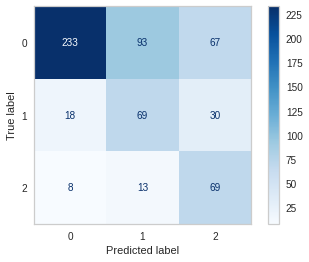

In [ ]:
#SVM is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new1,X_test_new1, selected_features1= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,35, features_train_extended[39])
model1= svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)
model1.fit(X_train_new1,y_train_resampled_extended)
y_pred1= model1.predict(X_test_new1)
balanced_accuracy1= balanced_accuracy_score(y_test,y_pred1)
print('The balanced accuracy of SVM classifier is', balanced_accuracy1)
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

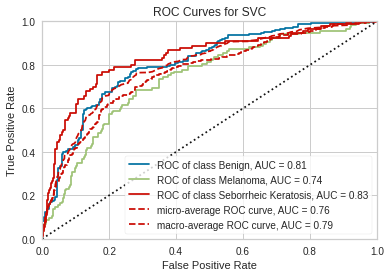

In [ ]:
plot_visualization= ROCAUC(model1,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new1,y_train_resampled_extended)
plot_visualization.score(X_test_new1,y_test)
plot_visualization.show()


Now, 10 additional models are trained on the dataset that maximized the accuracy for SVM model, which was the training augmented dataset (training+validation) balanced using SMOTE technique. Each of the ten models is trained and a search of the number of features that maximize the balanced accuracy for each model is found. 

# Second Model: Logistic Regression

In [ ]:
#An extensive search is done to find the set of features that maximizes the balanced accuracy for this model
model2= LogisticRegression(max_iter=2000,multi_class='auto',random_state=42)
max_balanced_accuracy_m2,selected_features_list_m2, selected_X_train_m2, selected_X_test_m2= ModelFeatureSelectionStatistics(len(features_train_extended[39].columns),
                                                                                                                  model2,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                  X_test_scaled2,
                                                                                                                  y_test,
                                                                                                                  features_train_extended[39])


The highest accuracy was 0.5520 selecting 13 features, out of 41 features.
 The selected features are:  ['Convexity Defects', 'Lesion Diameter', 'StdB', 'StdG', 'StdBGR', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity', 'MeanEnergy', 'skewness', 'entropy']


The balanced accuracy of Logistic Regression classifier is 0.55200408864531


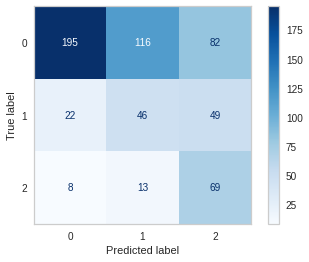

In [ ]:
#Logistic Regression classifier is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new2,X_test_new2, selected_features2= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,len(selected_features_list_m2),features_train_extended[39])
model2.fit(X_train_new2,y_train_resampled_extended)
y_pred2= model2.predict(X_test_new2)
balanced_accuracy2= balanced_accuracy_score(y_test,y_pred2)
print('The balanced accuracy of Logistic Regression classifier is', balanced_accuracy2)
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

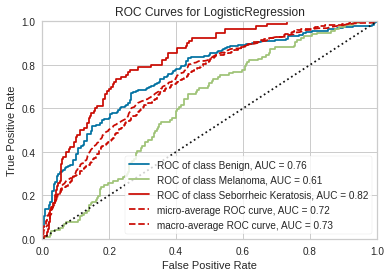

In [ ]:
plot_visualization= ROCAUC(model2,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new2,y_train_resampled_extended)
plot_visualization.score(X_test_new2,y_test)
plot_visualization.show()

# Third Model: Gradient Boosting



In [ ]:
#An extensive search is done to find the set of features that maximizes the balanced accuracy for this model
model3= GradientBoostingClassifier(random_state=42)
max_balanced_accuracy_m3,selected_features_list_m3, selected_X_train_m3, selected_X_test_m3= ModelFeatureSelectionStatistics(len(features_train_extended[39].columns),
                                                                                                                  model3,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                  X_test_scaled2,
                                                                                                                  y_test,
                                                                                                                  features_train_extended[39])

The highest accuracy was 0.6251 selecting 28 features, out of 41 features.
 The selected features are:  ['Convexity Defects', 'Circularity Index', 'Lesion Diameter', 'MeanB', 'meanBGR', 'StdB', 'StdG', 'StdR', 'StdBGR', 'maxG', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity', 'MeanEnergy', 'MeanContrast', 'meanS', 'meanHSV', 'meanCB', 'skewness', 'kurtosis', 'entropy', 'pixel_intensities', 'mean_BLAB', 'meanB_h1', 'meanG_h1', 'meanBGR_h1']


The balanced accuracy of Gradient Boosting classifier is 0.6251168961092626


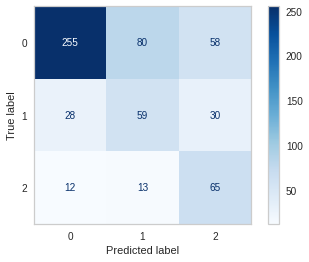

In [ ]:
#Gradient Boosting classifier is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new3,X_test_new3, selected_features3= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,len(selected_features_list_m3),features_train_extended[39])
model3.fit(X_train_new3,y_train_resampled_extended)
y_pred3= model3.predict(X_test_new3)
balanced_accuracy3= balanced_accuracy_score(y_test,y_pred3)
print('The balanced accuracy of Gradient Boosting classifier is', balanced_accuracy3)
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

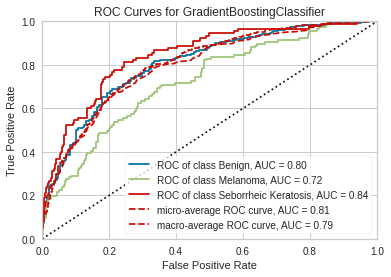

In [ ]:
plot_visualization= ROCAUC(model3,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new3,y_train_resampled_extended)
plot_visualization.score(X_test_new3,y_test)
plot_visualization.show()

# Fourth Model: Adaboost

In [ ]:
#An extensive search is done to find the set of features that maximizes the balanced accuracy for this model
model4= AdaBoostClassifier(random_state=42)
max_balanced_accuracy_m4,selected_features_list_m4, selected_X_train_m4, selected_X_test_m4= ModelFeatureSelectionStatistics(len(features_train_extended[39].columns),
                                                                                                                  model4,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                  X_test_scaled2,
                                                                                                                  y_test,
                                                                                                                  features_train_extended[39])

The highest accuracy was 0.6009 selecting 41 features, out of 41 features.
 The selected features are:  ['Convexity Defects', 'Circularity Index', 'Lesion Diameter', 'MeanB', 'MeanG', 'meanR', 'meanBGR', 'StdB', 'StdG', 'StdR', 'StdBGR', 'maxB', 'maxG', 'max_R', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity', 'MeanEnergy', 'MeanContrast', 'meanH', 'meanS', 'meanV', 'meanHSV', 'meanY', 'meanCR', 'meanCB', 'meanYCRCB', 'skewness', 'kurtosis', 'entropy', 'pixel_intensities', 'meanLAB', 'mean_L', 'mean_A', 'mean_BLAB', 'meanB_h1', 'meanG_h1', 'meanR_h1', 'meanBGR_h1']


The balanced accuracy of Adaboost Classifier is 0.6009351688741001


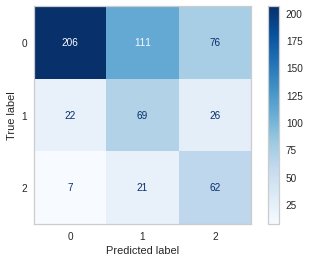

In [ ]:
#Adaboost classifier is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new4,X_test_new4, selected_features4= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,len(selected_features_list_m4),features_train_extended[39])
model4.fit(X_train_new4,y_train_resampled_extended)
y_pred4 = model4.predict(X_test_new4)
balanced_accuracy4= balanced_accuracy_score(y_test,y_pred4)
print('The balanced accuracy of Adaboost Classifier is', balanced_accuracy4)
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

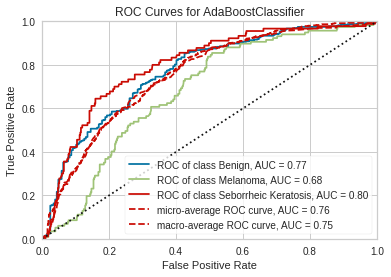

In [ ]:
plot_visualization= ROCAUC(model4,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new4,y_train_resampled_extended)
plot_visualization.score(X_test_new4,y_test)
plot_visualization.show()

# Fifth Model: Decision Tree Classifier

In [ ]:
#An extensive search is done to find the set of features that maximizes the balanced accuracy for this model
model5= DecisionTreeClassifier(random_state=42)
max_balanced_accuracy_m5,selected_features_list_m5, selected_X_train_m5, selected_X_test_m5= ModelFeatureSelectionStatistics(len(features_train_extended[39].columns),
                                                                                                                  model5,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                  X_test_scaled2,
                                                                                                                  y_test,
                                                                                                                  features_train_extended[39])

The highest accuracy was 0.5277 selecting 35 features, out of 41 features.
 The selected features are:  ['Convexity Defects', 'Circularity Index', 'Lesion Diameter', 'MeanB', 'MeanG', 'meanBGR', 'StdB', 'StdG', 'StdR', 'StdBGR', 'maxG', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity', 'MeanEnergy', 'MeanContrast', 'meanS', 'meanHSV', 'meanY', 'meanCR', 'meanCB', 'meanYCRCB', 'skewness', 'kurtosis', 'entropy', 'pixel_intensities', 'meanLAB', 'mean_L', 'mean_A', 'mean_BLAB', 'meanB_h1', 'meanG_h1', 'meanBGR_h1']


The balanced accuracy of Decision Tree Classifier is 0.5277331941454079


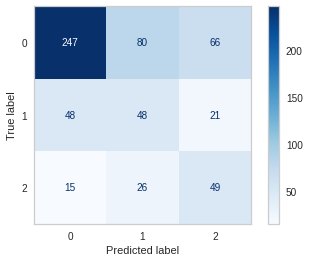

In [ ]:
#Decision Tree classifier is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new5,X_test_new5, selected_features5= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,len(selected_features_list_m5),features_train_extended[39])
model5.fit(X_train_new5,y_train_resampled_extended)
y_pred5 = model5.predict(X_test_new5)
balanced_accuracy5= balanced_accuracy_score(y_test,y_pred5)
print('The balanced accuracy of Decision Tree Classifier is', balanced_accuracy5)
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

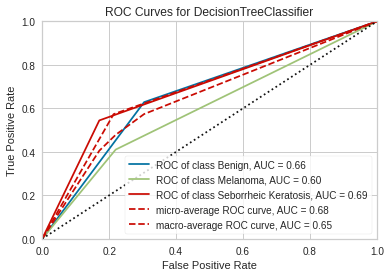

In [ ]:
plot_visualization= ROCAUC(model5,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new5,y_train_resampled_extended)
plot_visualization.score(X_test_new5,y_test)
plot_visualization.show()

# Sixth Model: Random Forest Classifier 

In [ ]:
#An extensive search is done to find the set of features that maximizes the balanced accuracy for this model
model6= RandomForestClassifier(random_state=42)
max_balanced_accuracy_m6,selected_features_list_m6, selected_X_train_m6, selected_X_test_m6= ModelFeatureSelectionStatistics(len(features_train_extended[39].columns),
                                                                                                                  model6,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                  X_test_scaled2,
                                                                                                                  y_test,
                                                                                                                  features_train_extended[39])

The highest accuracy was 0.5927 selecting 32 features, out of 41 features.
 The selected features are:  ['Convexity Defects', 'Circularity Index', 'Lesion Diameter', 'MeanB', 'meanBGR', 'StdB', 'StdG', 'StdR', 'StdBGR', 'maxG', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity', 'MeanEnergy', 'MeanContrast', 'meanS', 'meanHSV', 'meanCR', 'meanCB', 'meanYCRCB', 'skewness', 'kurtosis', 'entropy', 'pixel_intensities', 'meanLAB', 'mean_A', 'mean_BLAB', 'meanB_h1', 'meanG_h1', 'meanBGR_h1']


The balanced accuracy of Random Forest Classifier is 0.5927078575933538


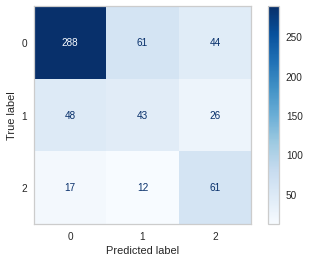

In [ ]:
#Random Forest classifier is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new6,X_test_new6, selected_features6= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,len(selected_features_list_m6),features_train_extended[39])
model6.fit(X_train_new6,y_train_resampled_extended)
y_pred6 = model6.predict(X_test_new6)
balanced_accuracy6= balanced_accuracy_score(y_test,y_pred6)
print('The balanced accuracy of Random Forest Classifier is', balanced_accuracy6)
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

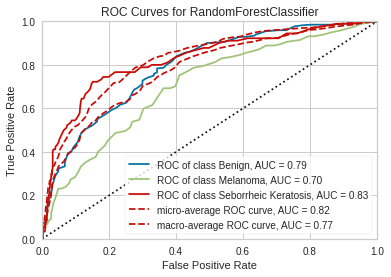

In [ ]:
plot_visualization= ROCAUC(model6,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new6,y_train_resampled_extended)
plot_visualization.score(X_test_new6,y_test)
plot_visualization.show()

# Seventh Model: XGBoost

In [ ]:
#An extensive search is done to find the set of features that maximizes the balanced accuracy for this model
model7= XGBClassifier(random_state=42)
max_balanced_accuracy_m7,selected_features_list_m7, selected_X_train_m7, selected_X_test_m7= ModelFeatureSelectionStatistics(len(features_train_extended[39].columns),
                                                                                                                  model7,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                  X_test_scaled2,
                                                                                                                  y_test,
                                                                                                                  features_train_extended[39])

The highest accuracy was 0.6247 selecting 28 features, out of 41 features.
 The selected features are:  ['Convexity Defects', 'Circularity Index', 'Lesion Diameter', 'MeanB', 'meanBGR', 'StdB', 'StdG', 'StdR', 'StdBGR', 'maxG', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity', 'MeanEnergy', 'MeanContrast', 'meanS', 'meanHSV', 'meanCB', 'skewness', 'kurtosis', 'entropy', 'pixel_intensities', 'mean_BLAB', 'meanB_h1', 'meanG_h1', 'meanBGR_h1']


The balanced accuracy of XGBoost Classifier is 0.6009351688741001


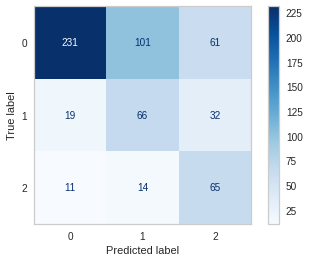

In [ ]:
#XGBoost classifier is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new7,X_test_new7, selected_features7= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,len(selected_features_list_m7),features_train_extended[39])
model7.fit(X_train_new7,y_train_resampled_extended)
y_pred7 = model7.predict(X_test_new7)
balanced_accuracy7= balanced_accuracy_score(y_test,y_pred7)
print('The balanced accuracy of XGBoost Classifier is', balanced_accuracy7)
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

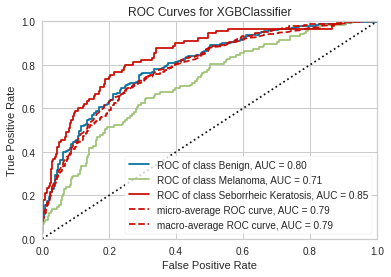

In [ ]:
plot_visualization= ROCAUC(model7,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new7,y_train_resampled_extended)
plot_visualization.score(X_test_new7,y_test)
plot_visualization.show()

# Eigth model: Naive Bayes

In [ ]:
#An extensive search is done to find the set of features that maximizes the balanced accuracy for this model
model8= GaussianNB()
max_balanced_accuracy_m8,selected_features_list_m8, selected_X_train_m8, selected_X_test_m8= ModelFeatureSelectionStatistics(len(features_train_extended[39].columns),
                                                                                                                  model8,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                  X_test_scaled2,
                                                                                                                  y_test,
                                                                                                                  features_train_extended[39])

The highest accuracy was 0.5376 selecting 39 features, out of 41 features.
 The selected features are:  ['Convexity Defects', 'Circularity Index', 'Lesion Diameter', 'MeanB', 'MeanG', 'meanR', 'meanBGR', 'StdB', 'StdG', 'StdR', 'StdBGR', 'maxB', 'maxG', 'max_R', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity', 'MeanEnergy', 'MeanContrast', 'meanH', 'meanS', 'meanHSV', 'meanY', 'meanCR', 'meanCB', 'meanYCRCB', 'skewness', 'kurtosis', 'entropy', 'pixel_intensities', 'meanLAB', 'mean_L', 'mean_A', 'mean_BLAB', 'meanB_h1', 'meanG_h1', 'meanBGR_h1']


The balanced accuracy of Naive Bayes Classifier is 0.5376111872295078


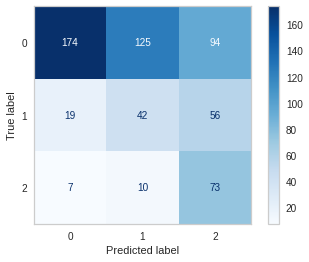

In [ ]:
#Naive Bayes classifier is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new8,X_test_new8, selected_features8= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,len(selected_features_list_m8),features_train_extended[39])
model8.fit(X_train_new8,y_train_resampled_extended)
y_pred8 = model8.predict(X_test_new8)
balanced_accuracy8= balanced_accuracy_score(y_test,y_pred8)
print('The balanced accuracy of Naive Bayes Classifier is', balanced_accuracy8)
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

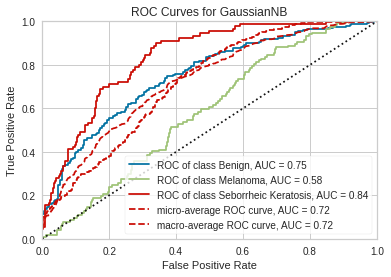

In [ ]:
plot_visualization= ROCAUC(model8,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new8,y_train_resampled_extended)
plot_visualization.score(X_test_new8,y_test)
plot_visualization.show()

# Ninth Model: KNeighbors Classifier

In [ ]:
#An extensive search is done to find the set of features that maximizes the balanced accuracy for this model
model9= KNeighborsClassifier()
max_balanced_accuracy_m9,selected_features_list_m9, selected_X_train_m9, selected_X_test_m9= ModelFeatureSelectionStatistics(len(features_train_extended[39].columns),
                                                                                                                  model9,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                  X_test_scaled2,
                                                                                                                  y_test,
                                                                                                                  features_train_extended[39])

The highest accuracy was 0.5596 selecting 19 features, out of 41 features.
 The selected features are:  ['Convexity Defects', 'Lesion Diameter', 'StdB', 'StdG', 'StdR', 'StdBGR', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity', 'MeanEnergy', 'MeanContrast', 'meanS', 'skewness', 'kurtosis', 'entropy', 'pixel_intensities', 'mean_BLAB']


The balanced accuracy of KNeighbors Classifier is 0.5595528587895


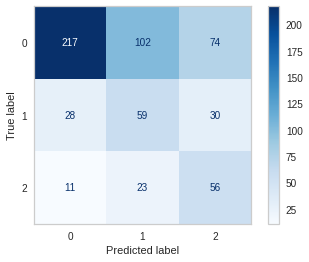

In [ ]:
#KNeighbors classifier is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new9,X_test_new9, selected_features9= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,len(selected_features_list_m9),features_train_extended[39])
model9.fit(X_train_new9,y_train_resampled_extended)
y_pred9 = model9.predict(X_test_new9)
balanced_accuracy9= balanced_accuracy_score(y_test,y_pred9)
print('The balanced accuracy of KNeighbors Classifier is', balanced_accuracy9)
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

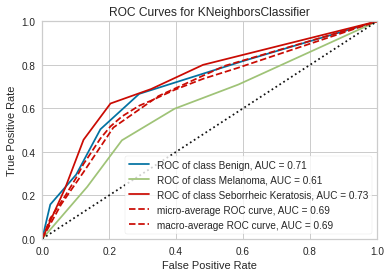

In [ ]:
plot_visualization= ROCAUC(model9,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new9,y_train_resampled_extended)
plot_visualization.score(X_test_new9,y_test)
plot_visualization.show()

# Tenth model: Bagging Classifier

In [ ]:
#An extensive search is done to find the set of features that maximizes the balanced accuracy for this model
model10= BaggingClassifier(base_estimator=svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42),n_estimators=10,random_state=42)
max_balanced_accuracy_m10,selected_features_list_m10, selected_X_train_m10, selected_X_test_m10= ModelFeatureSelectionStatistics(len(features_train_extended[39].columns),
                                                                                                                  model10,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                  X_test_scaled2,
                                                                                                                  y_test,
                                                                                                                  features_train_extended[39])

The highest accuracy was 0.6491 selecting 29 features, out of 41 features.
 The selected features are:  ['Convexity Defects', 'Circularity Index', 'Lesion Diameter', 'MeanB', 'meanBGR', 'StdB', 'StdG', 'StdR', 'StdBGR', 'maxG', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity', 'MeanEnergy', 'MeanContrast', 'meanS', 'meanHSV', 'meanCB', 'skewness', 'kurtosis', 'entropy', 'pixel_intensities', 'mean_A', 'mean_BLAB', 'meanB_h1', 'meanG_h1', 'meanBGR_h1']


The balanced accuracy of Bagging Classifier is 0.6491463865509667


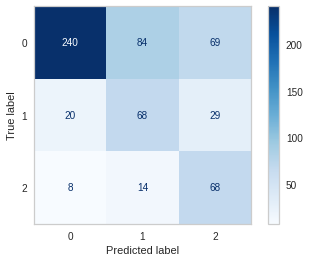

In [ ]:
#Bagging classifier is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new10,X_test_new10, selected_features10= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,len(selected_features_list_m10),features_train_extended[39])
model10.fit(X_train_new10,y_train_resampled_extended)
y_pred10= model10.predict(X_test_new10)
balanced_accuracy10= balanced_accuracy_score(y_test,y_pred10)
print('The balanced accuracy of Bagging Classifier is', balanced_accuracy10)
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

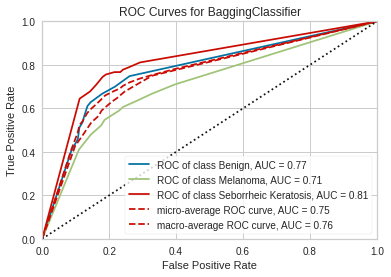

In [ ]:
plot_visualization= ROCAUC(model10,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new10,y_train_resampled_extended)
plot_visualization.score(X_test_new10,y_test)
plot_visualization.show()

# Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
#An extensive search is done to find the set of features that maximizes the balanced accuracy for this model
model11=get_stack_model()
max_balanced_accuracy_m11,selected_features_list_m11, selected_X_train_m11, selected_X_test_m11= ModelFeatureSelectionStatistics(len(features_train_extended[39].columns),
                                                                                                                  model11,
                                                                                                                  X_train_resampled_extended,
                                                                                                                  y_train_resampled_extended,
                                                                                                                   X_test_scaled2,
                                                                                                                  y_test,
                                                                                                                  features_train_extended[39])

The highest accuracy was 0.5422 selecting 12 features, out of 41 features.
 The selected features are:  ['Convexity Defects', 'Lesion Diameter', 'StdB', 'StdG', 'StdBGR', 'CV_B', 'CV_G', 'CV_R', 'MeanCorr', 'MeanHomogeneity', 'MeanEnergy', 'entropy']


The balanced accuracy of Stacking Classifier is 0.5422283116939606


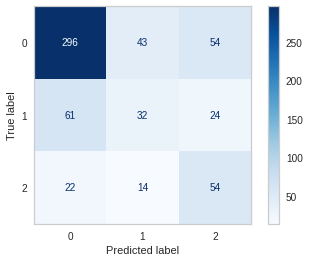

In [ ]:
#Stacking classifier is trained on the optimum dataframe and set of features. The classification repport and confusion matrix are generated.
X_train_new11,X_test_new11, selected_features11= feature_selection(X_train_resampled_extended,y_train_resampled_extended,X_test_scaled2,len(selected_features_list_m11),features_train_extended[39])
model11.fit(X_train_new11,y_train_resampled_extended)
y_pred11= model11.predict(X_test_new11)
balanced_accuracy11= balanced_accuracy_score(y_test,y_pred11)
print('The balanced accuracy of Stacking Classifier is', balanced_accuracy11)
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

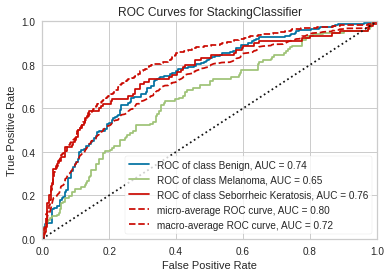

In [ ]:
plot_visualization= ROCAUC(model11,classes=['Benign','Melanoma','Seborrheic Keratosis'])
plot_visualization.fit(X_train_new11,y_train_resampled_extended)
plot_visualization.score(X_test_new11,y_test)
plot_visualization.show()